Reading data from /Users/vanshaj/Work/GitHub/Novard-Labs/Testing/Correlation/NIFTY 50-26-08-2024-to-26-08-2025.csv and /Users/vanshaj/Work/GitHub/Novard-Labs/Testing/Correlation/NIFTY BANK-26-08-2024-to-26-08-2025.csv...

Dataset 1 shape: (250, 7)
Dataset 2 shape: (250, 7)
Using 250 rows from each dataset for alignment
CORRELATION ANALYSIS RESULTS

1. PRICE CORRELATIONS:
   • Open Prices: 0.7517
   • Close Prices: 0.7554
   • Daily Returns: 0.8571

2. INTRA-DAY CORRELATIONS:
   • Asset 1 Open vs Close: 0.9850
   • Asset 2 Open vs Close: 0.9904

3. DATA SUMMARY:
   • Total trading days analyzed: 250
   • Days with valid returns data: 249

4. INTERPRETATION:
   • STRONG POSITIVE correlation (0.857) - Assets move together strongly


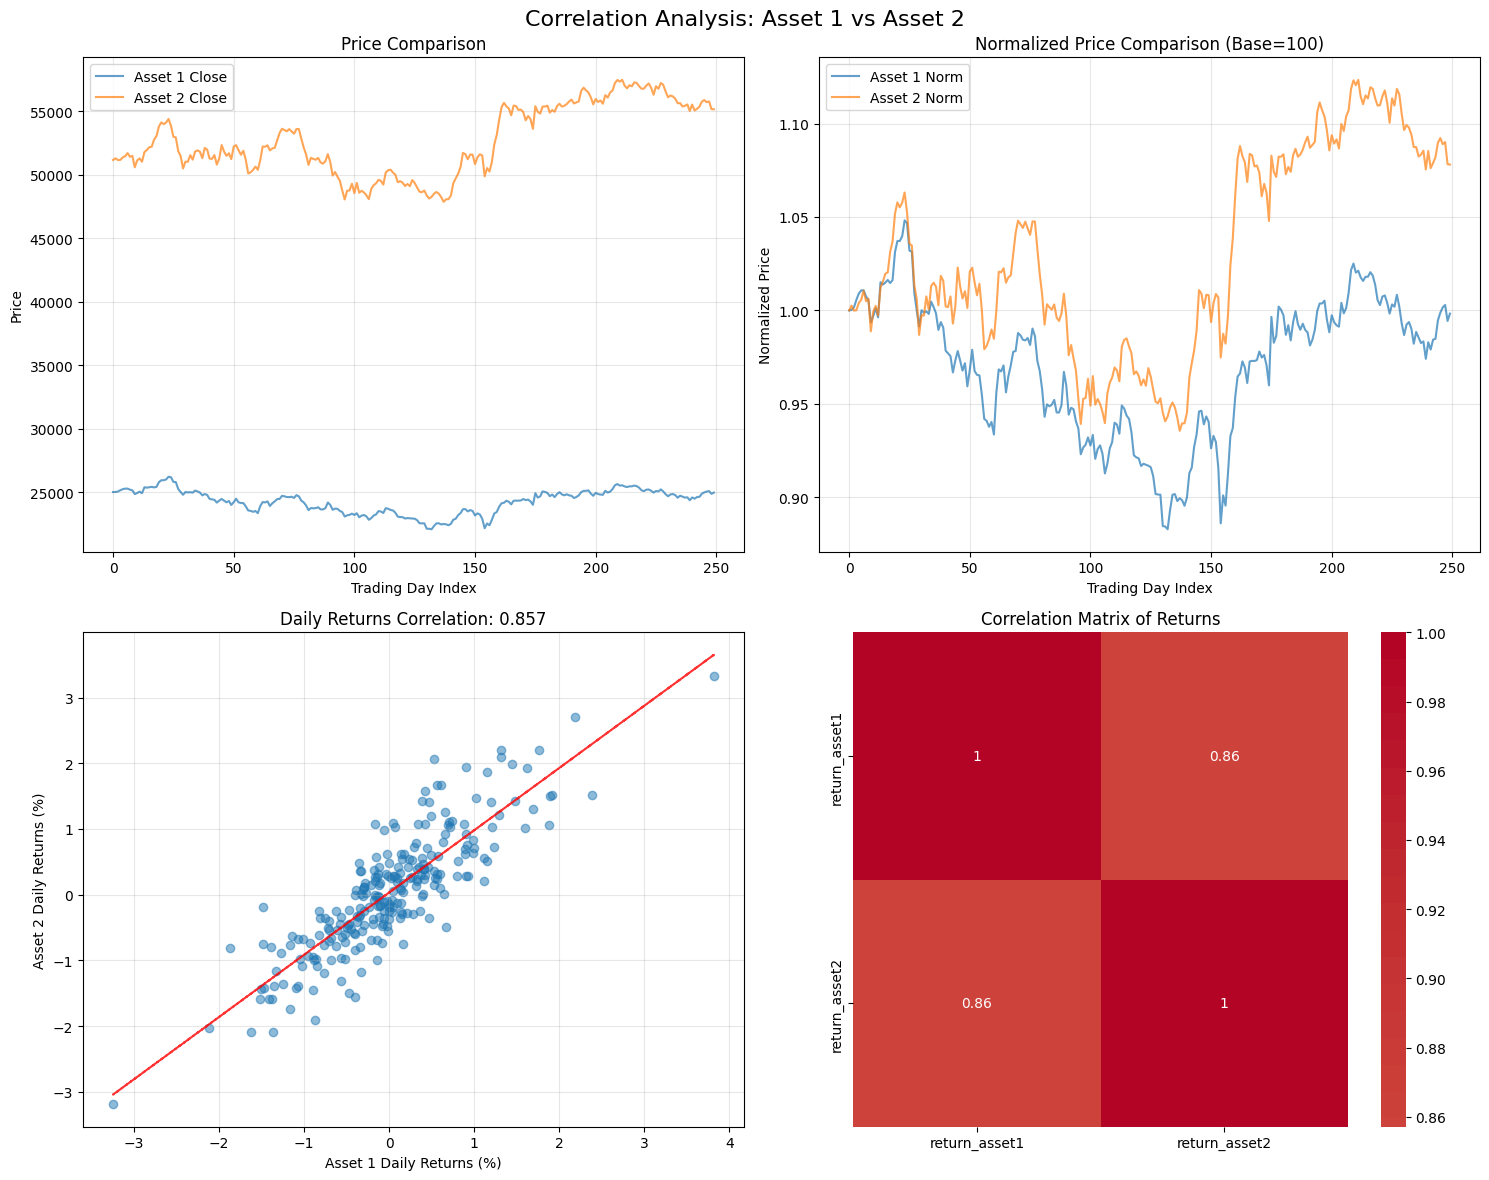


Combined data saved to 'combined_price_data.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_price_correlation(file1_path, file2_path, open_col='Open', close_col='Close'):
    try:
        # Read both CSV files
        print(f"Reading data from {file1_path} and {file2_path}...")
        
        df1 = pd.read_csv(file1_path)
        # Normalize column names (trim whitespace)
        df1.columns = df1.columns.str.strip()

        # helper: find a column name that matches the expected name in a tolerant way
        def _find_column(df, expected):
            if expected in df.columns:
                return expected
            # case-insensitive exact match
            for c in df.columns:
                if c.lower() == expected.lower():
                    return c
            # contains the expected substring (e.g. 'open_price', 'Open ')
            for c in df.columns:
                if expected.lower() in c.lower():
                    return c
            return None

        open_col1 = _find_column(df1, open_col)
        close_col1 = _find_column(df1, close_col)
        if open_col1 is None or close_col1 is None:
            print(f"File 1 columns: {list(df1.columns)}")
            raise ValueError(f"File 1 missing columns similar to '{open_col}' or '{close_col}'")

        # If the actual column name differs from the expected, rename it so rest of the code can use the
        # canonical names provided in open_col/close_col.
        if open_col1 != open_col or close_col1 != close_col:
            df1.rename(columns={open_col1: open_col, close_col1: close_col}, inplace=True)

        # Convert to numeric safely (remove thousand separators, coerce errors to NaN)
        df1[open_col] = pd.to_numeric(df1[open_col].astype(str).str.replace(',', ''), errors='coerce')
        df1[close_col] = pd.to_numeric(df1[close_col].astype(str).str.replace(',', ''), errors='coerce')

        df2 = pd.read_csv(file2_path)
        df2.columns = df2.columns.str.strip()

        open_col2 = _find_column(df2, open_col)
        close_col2 = _find_column(df2, close_col)
        if open_col2 is None or close_col2 is None:
            print(f"File 2 columns: {list(df2.columns)}")
            raise ValueError(f"File 2 missing columns similar to '{open_col}' or '{close_col}'")

        if open_col2 != open_col or close_col2 != close_col:
            df2.rename(columns={open_col2: open_col, close_col2: close_col}, inplace=True)

        df2[open_col] = pd.to_numeric(df2[open_col].astype(str).str.replace(',', ''), errors='coerce')
        df2[close_col] = pd.to_numeric(df2[close_col].astype(str).str.replace(',', ''), errors='coerce')
        
        # Display basic info about the datasets
        print(f"\nDataset 1 shape: {df1.shape}")
        print(f"Dataset 2 shape: {df2.shape}")
        
        # Check if required columns exist
        required_cols = [open_col, close_col]
        for df, name in zip([df1, df2], ['File 1', 'File 2']):
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"{name} missing columns: {missing_cols}")
        
        # Ensure both datasets have the same number of rows
        min_rows = min(len(df1), len(df2))
        df1 = df1.head(min_rows)
        df2 = df2.head(min_rows)
        
        print(f"Using {min_rows} rows from each dataset for alignment")
        
        # Create combined dataframe
        combined_df = pd.DataFrame({
            'open_asset1': df1[open_col],
            'close_asset1': df1[close_col],
            'open_asset2': df2[open_col],
            'close_asset2': df2[close_col]
        })
        
        # Calculate daily returns (percentage change)
        combined_df['return_asset1'] = combined_df['close_asset1'].pct_change() * 100
        combined_df['return_asset2'] = combined_df['close_asset2'].pct_change() * 100
        
        # Calculate correlations
        correlations = {
            'open_prices': combined_df['open_asset1'].corr(combined_df['open_asset2']),
            'close_prices': combined_df['close_asset1'].corr(combined_df['close_asset2']),
            'daily_returns': combined_df['return_asset1'].corr(combined_df['return_asset2']),
            'asset1_open_close': combined_df['open_asset1'].corr(combined_df['close_asset1']),
            'asset2_open_close': combined_df['open_asset2'].corr(combined_df['close_asset2'])
        }
        
        # Remove NaN values from returns
        returns_df = combined_df[['return_asset1', 'return_asset2']].dropna()
        
        return {
            'correlations': correlations,
            'combined_data': combined_df,
            'returns_data': returns_df
        }
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

def plot_correlation_analysis(results, asset1_name="Asset 1", asset2_name="Asset 2"):
    """
    Create visualizations for correlation analysis
    """
    if not results:
        return
    
    correlations = results['correlations']
    combined_df = results['combined_data']
    returns_df = results['returns_data']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Correlation Analysis: {asset1_name} vs {asset2_name}', fontsize=16)
    
    # Plot 1: Price comparison
    axes[0, 0].plot(combined_df.index, combined_df['close_asset1'], label=f'{asset1_name} Close', alpha=0.7)
    axes[0, 0].plot(combined_df.index, combined_df['close_asset2'], label=f'{asset2_name} Close', alpha=0.7)
    axes[0, 0].set_title('Price Comparison')
    axes[0, 0].set_xlabel('Trading Day Index')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Normalized price comparison
    norm_asset1 = combined_df['close_asset1'] / combined_df['close_asset1'].iloc[0]
    norm_asset2 = combined_df['close_asset2'] / combined_df['close_asset2'].iloc[0]
    axes[0, 1].plot(combined_df.index, norm_asset1, label=f'{asset1_name} Norm', alpha=0.7)
    axes[0, 1].plot(combined_df.index, norm_asset2, label=f'{asset2_name} Norm', alpha=0.7)
    axes[0, 1].set_title('Normalized Price Comparison (Base=100)')
    axes[0, 1].set_xlabel('Trading Day Index')
    axes[0, 1].set_ylabel('Normalized Price')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Returns scatter plot
    axes[1, 0].scatter(returns_df['return_asset1'], returns_df['return_asset2'], alpha=0.5)
    axes[1, 0].set_xlabel(f'{asset1_name} Daily Returns (%)')
    axes[1, 0].set_ylabel(f'{asset2_name} Daily Returns (%)')
    axes[1, 0].set_title(f'Daily Returns Correlation: {correlations["daily_returns"]:.3f}')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add regression line
    z = np.polyfit(returns_df['return_asset1'], returns_df['return_asset2'], 1)
    p = np.poly1d(z)
    axes[1, 0].plot(returns_df['return_asset1'], p(returns_df['return_asset1']), "r--", alpha=0.8)
    
    # Plot 4: Correlation heatmap
    corr_matrix = returns_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[1, 1])
    axes[1, 1].set_title('Correlation Matrix of Returns')
    
    plt.tight_layout()
    plt.show()

def display_results(results, asset1_name="Asset 1", asset2_name="Asset 2"):
    """
    Display correlation results in a formatted way
    """
    if not results:
        return
    
    correlations = results['correlations']
    combined_df = results['combined_data']
    
    print("=" * 60)
    print("CORRELATION ANALYSIS RESULTS")
    print("=" * 60)
    
    print(f"\n1. PRICE CORRELATIONS:")
    print(f"   • Open Prices: {correlations['open_prices']:.4f}")
    print(f"   • Close Prices: {correlations['close_prices']:.4f}")
    print(f"   • Daily Returns: {correlations['daily_returns']:.4f}")
    
    print(f"\n2. INTRA-DAY CORRELATIONS:")
    print(f"   • {asset1_name} Open vs Close: {correlations['asset1_open_close']:.4f}")
    print(f"   • {asset2_name} Open vs Close: {correlations['asset2_open_close']:.4f}")
    
    print(f"\n3. DATA SUMMARY:")
    print(f"   • Total trading days analyzed: {len(combined_df)}")
    print(f"   • Days with valid returns data: {len(results['returns_data'])}")
    
    print(f"\n4. INTERPRETATION:")
    corr_value = correlations['daily_returns']
    if corr_value > 0.7:
        print(f"   • STRONG POSITIVE correlation ({corr_value:.3f}) - Assets move together strongly")
    elif corr_value > 0.3:
        print(f"   • MODERATE POSITIVE correlation ({corr_value:.3f}) - Assets move together somewhat")
    elif corr_value > -0.3:
        print(f"   • WEAK/NO correlation ({corr_value:.3f}) - Little relationship in movements")
    elif corr_value > -0.7:
        print(f"   • MODERATE NEGATIVE correlation ({corr_value:.3f}) - Assets move somewhat oppositely")
    else:
        print(f"   • STRONG NEGATIVE correlation ({corr_value:.3f}) - Assets move strongly oppositely")


if __name__ == "__main__":

    
    # Replace these with your actual file paths
    file1_path = "/Users/vanshaj/Work/GitHub/Quant_Labs/QuantMathCourseWork/Application/LinearAlgebra/Data/NIFTY 50-26-08-2024-to-26-08-2025.csv"  # Replace with your first CSV file path
    file2_path = "/Users/vanshaj/Work/GitHub/Quant_Labs/QuantMathCourseWork/Application/LinearAlgebra/Data/NIFTY BANK-26-08-2024-to-26-08-2025.csv"  # Replace with your second CSV file path

    # Calculate correlations
    results = calculate_price_correlation(file1_path, file2_path)
    
    if results:
        # Display results
        display_results(results, "Asset 1", "Asset 2")
        
        # Create visualizations
        plot_correlation_analysis(results, "Asset 1", "Asset 2")
        
        # Optional: Save results to CSV
        results['combined_data'].to_csv('combined_price_data.csv', index=False)
        print(f"\nCombined data saved to 'combined_price_data.csv'")

/var/folders/y5/g1x0tvb16bbf0rjf7219mhmh0000gn/T/ipykernel_4820/533834167.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2023-12-31')
[*********************100%***********************]  4 of 4 completed


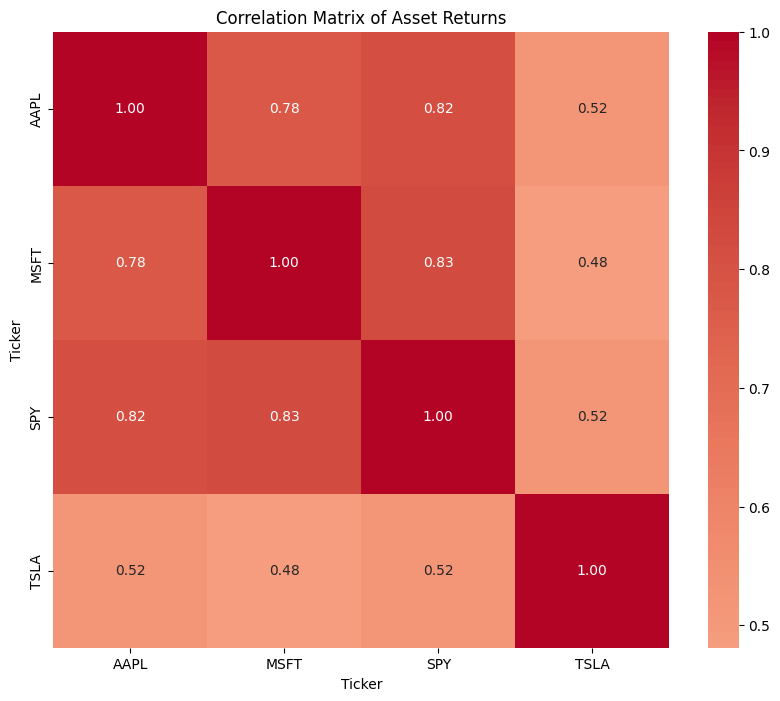

Correlation Matrix:
Ticker      AAPL      MSFT       SPY      TSLA
Ticker                                        
AAPL    1.000000  0.779637  0.817395  0.519958
MSFT    0.779637  1.000000  0.826905  0.481118
SPY     0.817395  0.826905  1.000000  0.523454
TSLA    0.519958  0.481118  0.523454  1.000000


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get the data
tickers = ['AAPL', 'MSFT', 'TSLA', 'SPY'] # SPY is S&P 500 ETF
data = yf.download(tickers, start='2020-01-01', end='2023-12-31')
# Check if 'Adj Close' is present and extract it, else use 'Close'
if 'Adj Close' in data.columns.levels[0]:
    adj_close = data['Adj Close']
elif 'Close' in data.columns.levels[0]:
    adj_close = data['Close']
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in downloaded data columns: {}".format(data.columns.levels[0]))
data = adj_close

# Step 2: Calculate Daily Returns (using log returns)
returns = np.log(data / data.shift(1)) # Alternatively: data.pct_change() for simple returns
returns = returns.dropna() # Remove the first row which has NaN

# Step 3: Calculate the Correlation Matrix
correlation_matrix = returns.corr(method='pearson') # 'pearson' is the default

# Step 4: Visualize the Correlation Matrix as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True, # Annotate the squares with the correlation value
            cmap='coolwarm', # Red (positive) and Blue (negative) color scale
            center=0, # Center the colormap at 0
            square=True,
            fmt=".2f") # Format annotations to 2 decimal places
plt.title('Correlation Matrix of Asset Returns')
plt.show()

# (Optional) Print the raw matrix
print("Correlation Matrix:")
print(correlation_matrix)